# An estimate of total number of infected people 

## Introduction

In this notebook, I will present a model to give an estimate of the total number of infected people for the current COVID-19 pandemic for some of the most impacted countries. 

The main idea behind the model here is to see data collected in different countries as _different experiments_ on the COVID-19 pandemics, which can be used to estimate some general proprieties of the pandemic. This is very resemblant of _Bayesian hierarchical models_ (see Chapter 5 of the wonderful [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/frontmatter.pdf) for an introduction), which give a natural way of estimating parameters (and their confidence intervals) that are common among the different experiments.   

In particular, I will use data about test coverage, number of measured cases and deaths to estimate the _global infection rate_ and the _global fatality rate_ for the COVID-19. These are then used (in combination with the total number of fatalities for each country) to estimate the total number of **infected people as the minimum number of people needed that are needed to be infected in each country in order to generate the observed number of fatalities.**

To obtain this, I will use two sources of data:
1. [the European Center for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide), to obtain data about the total number of observed cases and deaths at a country level;
2. [Our World in Data - COVID19 testing](https://ourworldindata.org/covid-testing), to obtain data about the number of performed tests for COVID-19 at a country level.


## Bayesian hierarchical model for infection and fatality rates

As discussed in the previous section, each country for which we have data on testing and fatalities for the COVID-19 can be seen as single experiment, part of a series of experiments, to estimate the distribution of the global infection and fatality rate.

Let me focus only on the infection rate here since the mathematical model that I will use for the fatality rate is the exactly the same for both.

Let be $y^i_j$ the number of people tested positive for the COVID-19 in $n^i_j$ tests performed by each country. We can so model the number of people tested positive as a binomial
\begin{equation}
y^i_j \sim \mathrm{Bin}\left ( n^i_j, \theta^{i}_j \right ) 
\end{equation}
where $ \theta^{i}_j$ is the infection rate at the country level. 

In this model,  $\theta^{i}_j$ can be seen as singular instance of a Beta distribution which represents the global infection rate

\begin{equation}
\theta^{i}_j \sim \mathrm{Beta}\left ( \alpha^i, \beta^i \right ) 
\end{equation}

where $\alpha^i$ and  $\beta^i$ are hyperparameters for this model. 

In order to estimate their distribution, we will use testing data $y^i = (y_1, \dots, y_n)$ and $\theta^{i} = (\theta^i_1, \dots, \theta^i_n)$ to maxime the posterior distribution


\begin{equation}
p(\alpha^i,\beta^i,\theta^i \mid y^i ) \propto p(y^i \mid \theta^i) p(\theta^i \mid \alpha^i,\beta^i) p(\alpha^i,\beta^i).
\end{equation}


Where $p(y^i \mid \theta^i)$ is a product of binomials, $p(\theta^i \mid \alpha^i,\beta^i)$ is a product of beta functions and $p(\alpha^i,\beta^i)$ is a **the joint prior distribution for $\alpha^i$ and $\beta^i$**.

Since we have almost no prior information on $\alpha^i$ and $\beta^i$, we can choose  a weakly informative prior for 

\begin{equation}
p(\alpha^i,\beta^i) \propto \left ( \alpha^i + \beta^i \right )^{-5/2}
\end{equation}

which assures a good coverage of the hyperparameter space whilst having a nice convergence for algorithms used to compute the posterior distribution.

Once that the posterior distributions for $\alpha^i$ and  $\beta^i$ are found, we can use them to construct a credible distribution for $\theta^{i}_T$, i.e. the **global infection rate for COVID-19** by computing  $\mathrm{Beta}\left ( \alpha^i, \beta^i \right )$ over a "large-enough" sample of the $\alpha^i$ and $\beta^i$  in the posterior space (see Chapter 5.3 [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/frontmatter.pdf) for more details). 


## A note about the code in this notebook

I have obtained the central part of this analysis, in particular the  inference of the hyperparameters of the beta distributions for the fatality and infection rate, by using the great library [PyMC3](https://peerj.com/articles/cs-55//) (Probabilistic Programming in Python), whose [website](https://docs.pymc.io/) are strongly encourage the reader to visit. 

## Global infection and fatality rates

Let me start by defining some useful functions, importing data from [the European Center for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) and [Our World in Data - COVID19 testing](https://ourworldindata.org/covid-testing) and merging them in one dataframe. 

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3.distributions.transforms as tr
import theano.tensor as tt
import scipy
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')


def number_of_infected_people(deaths,populations, p,confidence,steps=350):
    """
    Function to find the number of trials in a binomial distribution at confidence level alpha
    """
    
    nj = []
    
    for death, country_p in zip(deaths,populations):
        j=0
        binomSurvivalDist = 0.0
        n_v = np.logspace(np.log10(death*10),
                          np.log10(country_p),
                          num=steps)
        
        while binomSurvivalDist < confidence:
            if j < steps-1:
                n = n_v[j]
                binomSurvivalDist = scipy.stats.binom.sf(death, n, p)
                j +=1
            else:
                n = n_v[steps-1]
                binomSurvivalDist = confidence + 0.01
            
        nj.append(int(n))
    
    return np.array(nj)


def rate_estimate(x,n_bay_0=0,n_bay_1=0):
    """
    Estimate of the mortality rate using beta function
    """
    rate = scipy.stats.beta.ppf(0.5 , 
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return rate

def confidence_beta_distribution(x, alpha=0.90, n_bay_0=0,n_bay_1=0):
    """
    Estimate of the confidence intervals of the mortality rate using beta function
    """
    lower = scipy.stats.beta.ppf((1.0 - alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    upper = scipy.stats.beta.ppf((1.0 + alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return  upper - lower 


def create_df_country(df_world, country_name,n_bay_0=0,n_bay_1=0):
    """
    Create dataframe for country and order by days after first case. 
    """
    df_country = df_world[df_world["countriesAndTerritories"] == country_name]
    #df_country["date_time_date"] = pd.to_datetime(df_country[["year", "month","day"]])
    
    df_country = df_country.sort_values("date_time_date",ascending=True)    
    df_country["Total_cumulative_Cases"] = df_country["cases"].cumsum()
    df_country["Total_cumulative_Deaths"] = df_country["deaths"].cumsum()
    df_country["mortality_rate"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate, axis=1)
    df_country["mortality_error"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution, axis=1)
    df_country["mortality_relative_error"] = df_country["mortality_error"] / df_country["mortality_rate"]
    df_country["mortality_rate_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate,
                                                                                                       axis=1,
                                                                                                       n_bay_0=n_bay_0,
                                                                                                       n_bay_1=n_bay_1)
    df_country["mortality_error_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution,
                                                                                                        axis=1,
                                                                                                        n_bay_0=n_bay_0,
                                                                                                        n_bay_1=n_bay_1)
    
    df_country = df_country[df_country["Total_cumulative_Cases"]>0]
    first_day = df_country["date_time_date"].iloc[0]
    df_country["number_days"] =  [abs((day - first_day).days) for day in df_country["date_time_date"]]
    
    return df_country

      

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['figure.figsize'] = [10, 8] #larger plots

In [3]:
df_world_pop = pd.read_csv("our_world_in_data_world_population.csv") #population data from Our World in Data 
df_world_pop_2019 = df_world_pop[df_world_pop["Year"]=="2019"]
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United States", "United_States_of_America")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United Kingdom", "United_Kingdom")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("South Korea", "South_Korea")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United Arab Emirates", "United_Arab_Emirates")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Saudi Arabia", "Saudi_Arabia")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Dominican Republic", "Dominican_Republic")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Czech Republic", "Czechia")

In [4]:
df_world = pd.read_csv("COVID-19-geographic-disbtribution-worldwide-2020-04-30.csv") #cases and causalities from ECPD
df_world = pd.merge(df_world, df_world_pop_2019, left_on = "countriesAndTerritories", right_on= "Entity", how="left") #merging data
df_world["population_per_million"] = np.round(df_world["popData2018"] / 10**6,2)
df_world["date_time_date"] = pd.to_datetime(df_world[["year", "month","day"]])

In [5]:
tests_per_country = pd.read_csv("full-list-total-tests-for-covid-19.csv") #testing data from Our World in Data

tests_per_country["Entity"] = tests_per_country["Entity"].replace("United States", "United_States_of_America")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("United Kingdom", "United_Kingdom")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("South Korea", "South_Korea")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("United Arab Emirates", "United_Arab_Emirates")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Saudi Arabia", "Saudi_Arabia")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Dominican Republic", "Dominican_Republic")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Czech Republic", "Czechia")

tests_per_country["date_time_date"] = [ datetime.datetime.strptime(date, '%b %d, %Y') for date in tests_per_country["Date"].tolist() ]
tests_per_country = tests_per_country.rename(columns={"Entity": "countriesAndTerritories", "B": "c"})

In [6]:
df_world = pd.merge(df_world, tests_per_country, on=['countriesAndTerritories', 'date_time_date'],how="inner") #merging data from EPCD and OWD 

In [7]:
top50_countries = df_world.groupby("countriesAndTerritories").sum().sort_values("cases", ascending=False).reset_index().head(50)["countriesAndTerritories"].tolist()

n_world_top50_cases = df_world[df_world["countriesAndTerritories"].isin(top50_countries)]["cases"].sum()
n_world_top50_death = df_world[df_world["countriesAndTerritories"].isin(top50_countries)]["deaths"].sum()

dict_of_df = {} #dictionary of dataframe, one for each country with data from the 50 most impacted countries

for country in top50_countries:
    
    df = create_df_country(df_world, country, n_bay_0=n_world_top50_death,n_bay_1=n_world_top50_cases)  

    dict_of_df[country] = df   

Let me here retrieve from each country's dataframe the total number of cases, casualties, tests and population for the 50 most impacted countries as of **the last day available (here the 30th of April 2020).**

In [8]:
cases_country = []
pop_country = []
tests_country = []
deaths_country = []

for country in top50_countries:
        
    df = dict_of_df[country]
    cases_country.append(df.iloc[-1]["Total_cumulative_Cases"])
    pop_country.append(df.iloc[-1]["Population"])
    tests_country.append(df.iloc[-1]["Total tests"])
    deaths_country.append(df.iloc[-1]["Total_cumulative_Deaths"])

deaths_country = np.array(deaths_country)
cases_country = np.array(cases_country)
pop_country = np.array(pop_country)
tests_country = np.array(tests_country)
N=len(cases_country)

## Estimating the infection rate with hierarchical Bayesian model

As seen in the previous section, we can estimate the posterior distribution for $\theta^{i}_T$, given the number of tests and observed infected people thanks to a hierarchical Bayesian model, which I will implement here using pymc3. 

As the reader can seen below, it is pretty simple to define the model discussed in the previous sections in pymc3 and generate posterior samples, whose number I fix here to 1000.

In [9]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_dis = pm.HalfFlat('ab_dis',
                     shape=2)
    
    pm.Potential('p(a, b)_dis', logp_ab(ab_dis))

    X_dis = pm.Deterministic('X_dis', tt.log(ab_dis[0]/ab_dis[1]))
    Z_dis = pm.Deterministic('Z_dis', tt.log(tt.sum(ab_dis)))
            
    theta_dis= pm.Beta('theta_dis', alpha=ab_dis[0], beta=ab_dis[1],shape=N)
    
    n_cases = pm.Binomial('n_cases', n=tests_country, p=theta_dis, observed=cases_country)

    trace_dis = pm.sample(1000, tune=2000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_dis, ab_dis]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:25<00:00, 236.59draws/s]


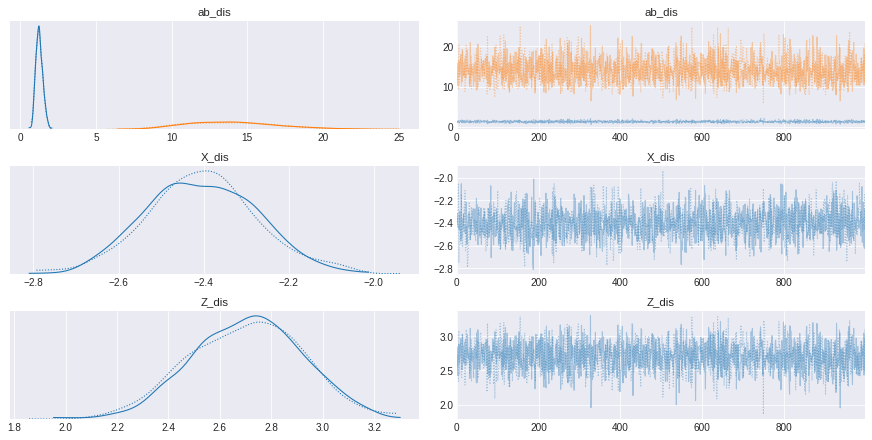

In [10]:
pm.traceplot(trace_dis, var_names=['ab_dis', 'X_dis', 'Z_dis']);

The trace looks pretty good and likelihood maximization has converged, so we can be quite confident about the results obtained for the posterior distribution. 

In particular, we obtained the posterior distribution for the hyperparameters $\alpha^i$ and $\beta^i$ (called here _ab_), thanks to which we can compute the posterior distribution for $\theta^{i}_T$. 

In [11]:
theta_dis = [scipy.stats.beta.ppf(0.5,a_dis,b_dis) for  a_dis, b_dis in trace_dis['ab_dis']]

(0.0, 43.0)

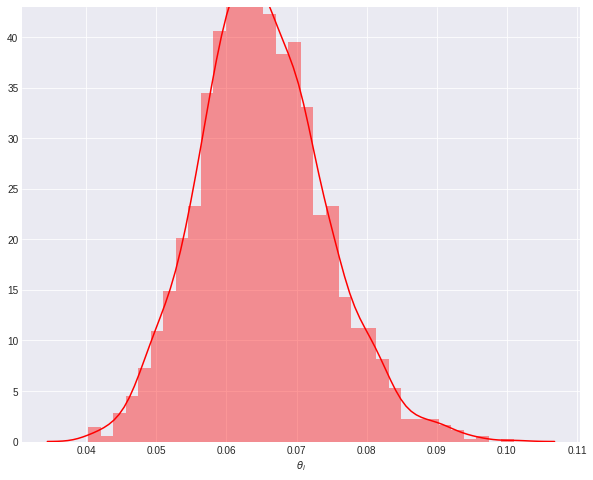

In [12]:
sns.distplot(np.array(theta_dis),color='r');
plt.xlabel(r'$\theta_i$');
plt.ylim(0,43)

That, with a 90 % confidence interval, gives an estimate $\theta^{i}_T \in \left [ 0.05 , 0.08 \right ]$. 

## Estimate of the fatality rate

We can use the same technique to estimate $\theta^{f}_T$ (and its hyperparameters).

In [13]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_mort = pm.HalfFlat('ab_mort',
                     shape=2)
    
    pm.Potential('p(a, b)_mort', logp_ab(ab_mort))

    X_mort = pm.Deterministic('X_mort', tt.log(ab_mort[0]/ab_mort[1]))
    Z_mort = pm.Deterministic('Z_mort', tt.log(tt.sum(ab_mort)))
    
    theta_mort= pm.Beta('theta_mort', alpha=ab_mort[0], beta=ab_mort[1],shape=N)
    
    n_deaths = pm.Binomial('n_deaths', n=cases_country, p=theta_mort, observed=deaths_country)
    
    
    trace_mort = pm.sample(1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_mort, ab_mort]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:10<00:00, 572.44draws/s] 


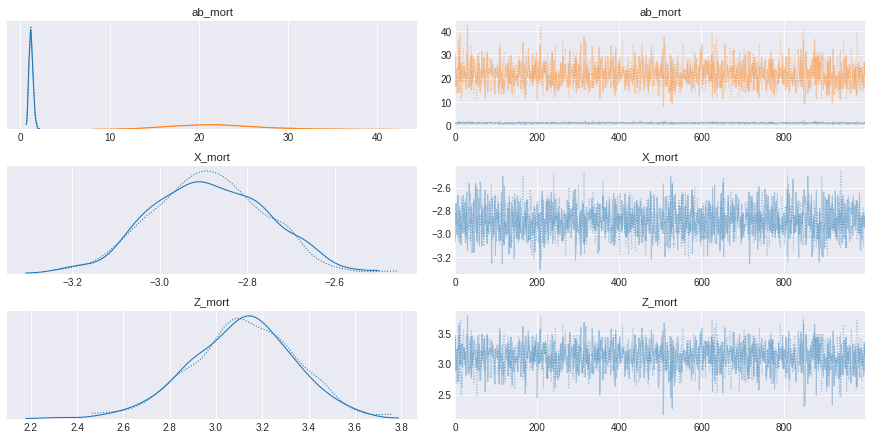

In [14]:
pm.traceplot(trace_mort, var_names=['ab_mort', 'X_mort', 'Z_mort']);

In [15]:
theta_mort = [scipy.stats.beta.ppf(0.5,a_mort,b_mort) for  a_mort, b_mort in trace_mort['ab_mort']]

Text(0.5, 0, '$\\theta_m$')

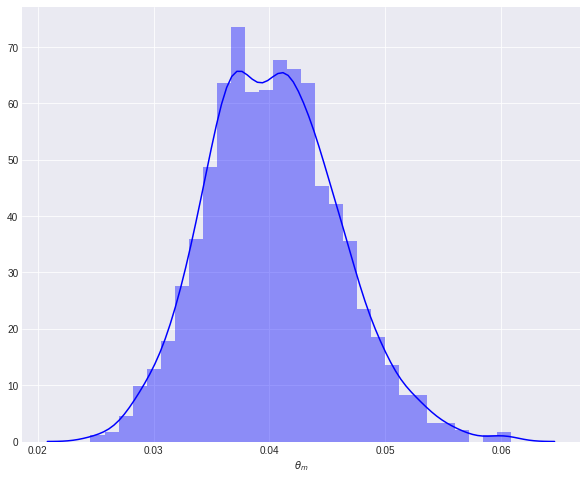

In [16]:
sns.distplot(np.array(theta_mort),color='b');
plt.xlabel(r'$\theta_m$')

That gives with a 90 % confidence interval, we obtain an estimate of $\theta^{f}_T \in \left [ 0.03 , 0.05 \right ]$. 


Using the estimate of the hyperparameters for $\theta^{i}_T$ and $\theta^{f}_T$, **one can construct a credible distribution for $\theta^{t}_T$ evaluating a beta function on all samples from the infection and the fatality rates** 


In [17]:
theta_tot_elements = [scipy.stats.beta.ppf(0.5,a_dis,b_dis)*scipy.stats.beta.ppf(0.5,a_mort,b_mort) for a_dis,  b_dis, a_mort, b_mort in list(zip(trace_dis['ab_dis'][:,0],trace_dis['ab_dis'][:,1],trace_mort['ab_mort'][:,0],trace_mort['ab_mort'][:,1]))]

Text(0.5, 0, '$\\theta_t$')

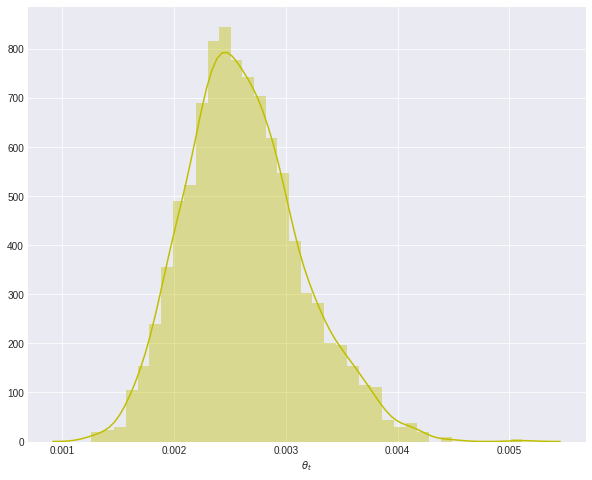

In [18]:
sns.distplot(np.array(theta_tot_elements),color='y');
plt.xlabel(r'$\theta_t$')

In [19]:
theta_tot = np.percentile(theta_tot_elements,50)
theta_tot_low = np.percentile(theta_tot_elements,5)
theta_tot_upper = np.percentile(theta_tot_elements,95)

witch gives an estimate with 90 % of confidence of $\theta^{t}_T \in \left [ 0.0022 , 0.0039 \right ]$ with median value of $\bar{\theta}^{t}_T = 0.0029$.


## Estimating the total number of infections for COVID-19

As seen in the previous section, testing data can be used to estimate the global infection rate for COVID-19. Similarly, we can use causalities data to estimate the general fatality rate $\theta^{f}_T$ for COVID-19. 

These two quantities can be used to estimate the total number of infected people by seeing a fatality due to the COVID-19 as a two step process. In this framework, each member of a population has a probability of getting infected equal to $\theta^{i}_T$ and, if this happens, it has a probability of deceasing of $\theta^{f}_T$. 


In fact, we can compute a credible distribution for $\theta^{p}_T$, **the fatality rate over the entire population**, as


\begin{equation}
\theta^{t}_T \sim \mathrm{Beta} \left (\alpha^i, \beta^i  \right ) \times \mathrm{Beta} \left (\alpha^f, \beta^f  \right ),
\end{equation}

using the posterior samples for $\alpha^i$, $\beta^i$, $\alpha^f$ and $\beta^f$. 

The "total fatality rate" $\theta^{p}_T$, can be used to model the number of fatalities as for each country as*

\begin{equation}
y^d_j \sim \mathrm{Bin}\left ( n^{ti}_j, \theta^{t}_T \right ) 
\end{equation}

where $n^{ti}_j$ is the **total infected number people in each country**.

We can use the latter modelization to estimate $n^{ti}_j$  by numerically inverting the Binomial distribution,  within a certain confidence level (90% for this study) at using the median value of the $\theta^{t}_T$ as the probability. Since we have access to the whole distribution for $\theta^{t}_T$, we can also compute confidence intervals for $n^{ti}_j$ by using the 5% and 95% percentile values for $\theta^{t}_T$ to invert the Binomial distribution.  

In [20]:
true_cases = number_of_infected_people(deaths_country,pop_country,theta_tot,0.9)
true_cases_up = number_of_infected_people(deaths_country,pop_country,theta_tot_low,0.9)
true_cases_low = number_of_infected_people(deaths_country,pop_country,theta_tot_upper,0.9)

That can used to compute the estimate of the percentage of total population that has been infected for each country: 

In [21]:
perc_contaged_country = true_cases / pop_country 
lower_bound_perc_contaged_country = (true_cases - true_cases_low) / pop_country
upper_bound_perc_contaged_country = (true_cases_up - true_cases)  / pop_country

And also to estimate the ratio between the total number of infected people and the observed number of infected people:

In [22]:
ratio_true_cases_cases = true_cases / cases_country
lower_bound_ratio_true_cases_cases = (true_cases - true_cases_low) /  cases_country
upper_bound_ratio_true_cases_cases = (true_cases_up - true_cases) /  cases_country

## Analysis of the results

Let me start by plotting the ratio between the estimated total number of infected people and the observed cases against the number of observed cases for each country in this study. 

(3.0, 6.1)

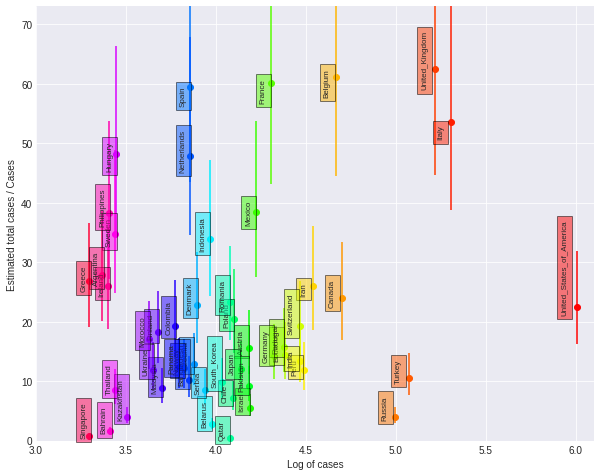

In [23]:
cmap = plt.cm.get_cmap("hsv", len(top50_countries)+1)


from random import shuffle

x = np.arange(0,10) # just a straight line 

for country, j in zip(top50_countries,range(len(top50_countries))):
         
    plt.errorbar(np.log10(cases_country[j]), 
                 ratio_true_cases_cases[j],
             linestyle = ' ',
             marker = 'o',
             yerr = [[lower_bound_ratio_true_cases_cases[j]],
                     [upper_bound_ratio_true_cases_cases[j]]],
             label = country,
             color = cmap(j) )
    
    plt.text(np.log10(cases_country[j])*0.985, 
                 ratio_true_cases_cases[j]*0.95,
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(j), alpha=0.5),
            rotation=90)

#plt.legend()
plt.xlabel("Log of cases")
plt.ylabel("Estimated total cases / Cases")
plt.ylim(-0.1,73)
plt.xlim(3,6.1)

within this model, _it does not seem to be strong correlation between the number of cases and the ratio between the estimated total number of infected people and the observed cases_. 

It seems however to be a positive correlation between this ratio and the number of observed death, as expressed by the following plot:

(0.5, 5.0)

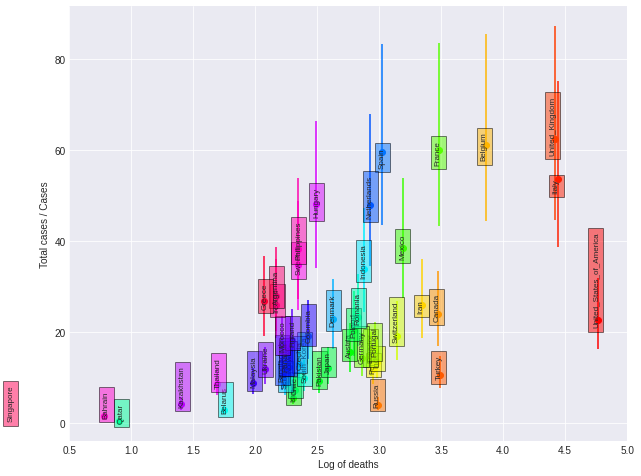

In [26]:
cmap = plt.cm.get_cmap("hsv", len(top50_countries)+1)


from random import shuffle

x = np.arange(0,10) # just a straight line 

for country, j in zip(top50_countries,range(len(top50_countries))):
         
    plt.errorbar(np.log10(deaths_country[j]), 
                 ratio_true_cases_cases[j],
             linestyle = ' ',
             marker = 'o',
             yerr = [[lower_bound_ratio_true_cases_cases[j]],
                     [upper_bound_ratio_true_cases_cases[j]]],
             label = country,
             color = cmap(j) )
    
    plt.text(np.log10(deaths_country[j])*0.99, 
                 ratio_true_cases_cases[j]*0.95,
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(j), alpha=0.5),
            rotation=90)

plt.xlabel("Log of deaths")
plt.ylabel("Total cases / Cases")
plt.xlim(0.5,5.0)

This is probably due to the fact that once the epidemic in each country becomes very violent (and an increase of the number of observed death is a good proxy of when this happen), it becomes increasingly more difficult to test people since a lot of resources are devoted into curing patients (see the notebook **COVID-19 - Fatality rates, a Bayesian approach** for more details).


Using the results obtained below, we can plot the estimated percentage of infected people over the total population for each country as a function of the country population (and the green horizontal line corresponds to the 80% percentile). 

(6.0, 9.2)

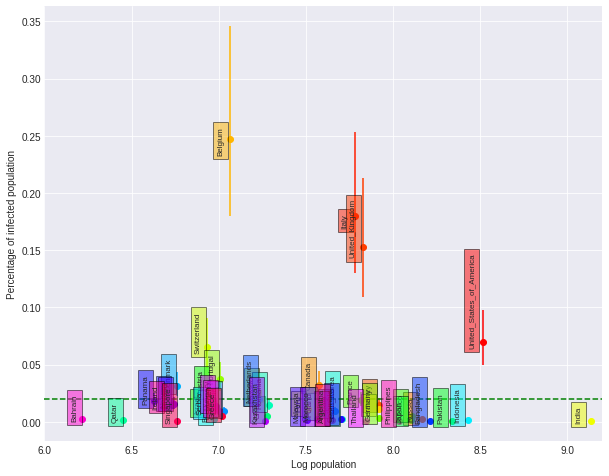

In [25]:
cmap = plt.cm.get_cmap("hsv", len(top50_countries)+1)


from random import shuffle

x = np.arange(0,10) # just a straight line 

for country, j in zip(top50_countries,range(len(top50_countries))):
         
    plt.errorbar(np.log10(pop_country[j]), 
                 perc_contaged_country[j],
             linestyle = ' ',
             marker = 'o',
             yerr = [[lower_bound_perc_contaged_country[j]],
                     [upper_bound_perc_contaged_country[j]]],
             label = country,
             color = cmap(j) )
    
    plt.text(np.log10(pop_country[j])*0.99, 
                 perc_contaged_country[j]*0.95,
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(j), alpha=0.5),
            rotation=90)

plt.xlabel("Log population")
plt.ylabel("Percentage of infected population")
plt.hlines(np.percentile(perc_contaged_country,80),6,9.5, linestyles='--',color='g')
plt.xlim(6,9.2)

As we can see, for most of the countries in this study the percentage of estimated infected people lies between 1 and 5 %.

There are however some notable outliers (Belgium, Italy, USA, UK, the Netherlands, Switzerland, Denmark, ...), which correspond to some of the nations that have been hit the most by the current pandemic.

In particular, as of today **29/04/2020** the situation seems dramatic in particular for Italy and the USA and I will reserve a particular focus on these countries for a further study.

## Conclusions 

In this notebook I have presented an approach, based on Hierarchical Bayesian Models, to estimate the **general infection and fatality rates** and to use these results to estimate the **total number of infected people in each country in this study.**

The most important take away is probably that there is a **strong correlation between the number of observed deaths and the percentage of infected population for each country.**

These relations are however time dependent because of the ongoing fast spread of the pandemic and their time stability might deserve a further study, which are collected in the notebook **COVID-19  - An estimate of the total number of infected people- Bayesian parameter stability.**